In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import json
import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.utils import plot_model

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
dataset_name = "SEG_CNNLSTM_1_retrain"

In [4]:
timestamp = "20201203-101815"

In [5]:
#model = keras.models.load_model("version/{}".format(timestamp))
model = keras.models.load_model("version/{}/model.h5".format(timestamp))

In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 64, 152)           59437016  
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 152)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 80)                61760     
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)                0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 8, 80)             0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 8, 336)            334656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 336)           

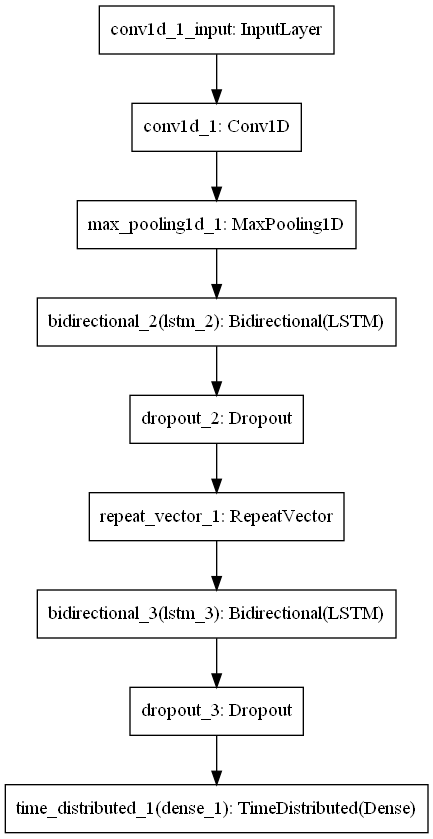

In [8]:
plot_model(model, to_file="version/{}/figure.png".format(timestamp))

In [7]:
vocabulary = np.genfromtxt("static/vocabulary.csv", delimiter="\n", dtype=np.int64)
vocab_size = vocabulary.shape[0]
vocab_size

16293

In [8]:
param_list = dict()

param_list["PAST_HISTORY"] = 64
param_list["FUTURE_TARGET"] = 8
param_list["BATCH_SIZE"] = 16
param_list["VOCAB_SIZE"] = vocab_size

In [9]:
test_set = np.genfromtxt("data/{}_test_set.csv".format(dataset_name), delimiter="\n", dtype=np.int64)
test_set

array([ 172, 2711,  326, ...,    0,    6,    0], dtype=int64)

In [10]:
x_test = tf.data.Dataset.from_tensor_slices(test_set[:-param_list["FUTURE_TARGET"]]).window(param_list["PAST_HISTORY"], 1, 1, True)
x_test = x_test.flat_map(lambda x: x.batch(param_list["PAST_HISTORY"])) 
x_test = x_test.map(lambda x: tf.one_hot(x, param_list["VOCAB_SIZE"], axis=-1))
x_test = x_test.batch(param_list["BATCH_SIZE"])

In [11]:
y_test = tf.data.Dataset.from_tensor_slices(test_set[param_list["PAST_HISTORY"]:]).window(param_list["FUTURE_TARGET"], 1, 1, True)
y_test_slices = y_test.flat_map(lambda y: y.batch(param_list["FUTURE_TARGET"]))
y_test = y_test_slices.map(lambda y: tf.one_hot(y, param_list["VOCAB_SIZE"], axis=-1))
y_test = y_test.batch(param_list["BATCH_SIZE"])

In [12]:
test_data = tf.data.Dataset.zip((x_test, y_test))

In [13]:
loss, acc = model.evaluate(test_data)

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential_1/conv1d_1/conv1d (defined at <ipython-input-13-6a908162ad29>:1) ]] [Op:__inference_test_function_6214]

Function call stack:
test_function


In [14]:
#y_pred = tf.argmax(model.predict(x_test), axis=-1).numpy()     # Unable to predict whole test_set at a time
y_pred = []
for x in x_test:
    y_pred.extend(tf.argmax(model.predict(x), axis=-1).numpy())
y_pred = np.array(y_pred)

In [15]:
y_true = np.array([yt for yt in y_test_slices.as_numpy_iterator()])

In [16]:
p, r, f = [], [], []
average_method = ["micro", "macro", "weighted"]

for method in average_method:
    precision = precision_score(np.ravel(y_true), np.ravel(y_pred), average=method)
    recall = recall_score(np.ravel(y_true), np.ravel(y_pred), average=method)
    f1 = f1_score(np.ravel(y_true), np.ravel(y_pred), average=method)
     
    p.append(precision)
    r.append(recall)
    f.append(f1)

In [17]:
report = pd.DataFrame(data=[p, r, f], columns=average_method, index=["precision", "recall", "f1"])
report

,micro,macro,weighted
precision,0.524549,0.427915,0.511833
recall,0.524549,0.413273,0.524549
f1,0.524549,0.389772,0.489183


In [18]:
accuracy = pd.DataFrame(data=[[loss, acc]], columns=["loss", "accuracy"])
accuracy

,loss,accuracy
0,2.25287,0.524549


In [19]:
report.to_csv("version/{}/report.csv".format(timestamp))
accuracy.to_csv("version/{}/accuracy.csv".format(timestamp), index=False)